<a href="https://colab.research.google.com/github/gotomanivannan/Traffic-Sign-Recognition/blob/main/TSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import Libraries

In [8]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
#tf.keras.layers.Flatten( data_format=None, **kwargs )
#from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import warnings
from skimage import exposure
# Load pickled data
import pickle

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
## Load the data

training_file = "./sample_data/train.p"
testing_file = "./sample_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X, y = train['features'], train['labels']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=4000, random_state=0)

X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
N_CLASSES = np.unique(y_train).size  # keep this for later

X_train shape: (35209, 32, 32, 3)
y_train shape: (35209,)
X_valid shape: (4000, 32, 32, 3)
y_valid shape: (4000,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


In [9]:
# Data Analysis

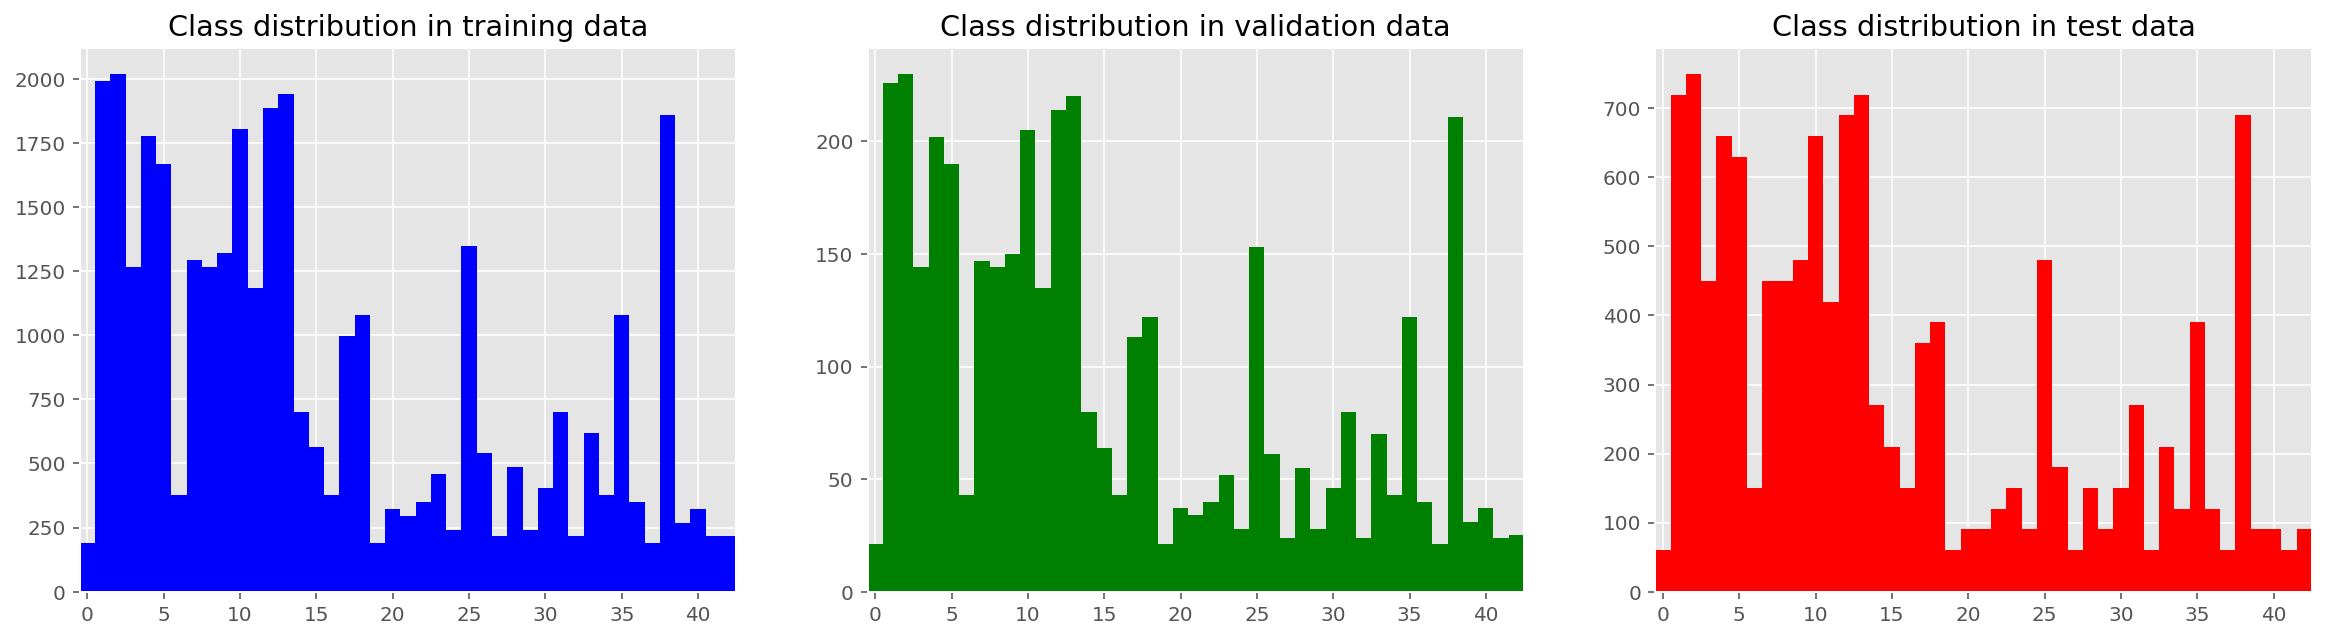

In [13]:
def plot_dist(y_data, title=None, ax=None, **kwargs):
    '''
    Plot the traffic sign class distribution
    '''
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, N_CLASSES+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5,N_CLASSES-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig,ax = plt.subplots(1,3, figsize=(20,5))
plot_dist(y_train, title='Class distribution in training data', ax=ax[0], color='blue')
plot_dist(y_valid, title='Class distribution in validation data', ax=ax[1], color='green')
plot_dist(y_test, title='Class distribution in test data', ax=ax[2], color='red')

In [10]:
# Sign and class labels mappings

In [17]:
## let's create a pandas dataframe to load csv

sign_name_df = pd.read_csv('./sample_data/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId',inplace=True)
sign_name_df.head()

AttributeError: ignored

In [ ]:
## Helper function for finding lables for class-id (later used)
def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return sign_name_df.loc[label].SignName

In [11]:
# Helper function for plotting accuracy graphs and confusion matrix

In [ ]:
def show_learning_curve(train, valid, epochs=range(1, 21, 1)):
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='validation')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.xticks(epochs)
    plt.legend(loc='center right')

def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()

def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))

# Let's check occuranes of different signs

In [ ]:
sign_name_df['Occurence'] = [sum(y_train == c) for c in range(N_CLASSES)]
sign_name_df.sort_values('Occurence', ascending=False)

In [ ]:
def get_samples(num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        if len(list(np.where(y_train==class_id))[0].tolist()) < num_samples:
            num_samples = len(list(np.where(y_train==class_id))[0].tolist())
        indices = random.sample(list(np.where(y_train==class_id))[0].tolist(), num_samples)
        return X_train[indices], y_train[indices]
    else:
        indices = np.random.choice(X_train.shape[0], size=num_samples, replace=False)
        return X_train[indices], y_train[indices]

In [ ]:
def show_images(sample_x, sample_y, cols=5, sign_names=None, show_shape=False):
    """
    Given a list of images, load and show them.
    """
    
    num_images = len(sample_x)
    rows = num_images//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4,rows*2.5))
    indexes = range(cols * rows)
    i = 1 
    for ax, index in zip(axes.flat, indexes):    
        image = sample_x[index]
        label = sample_y[index]
        if image.shape[2] == 1:
            ax.imshow(image.reshape(32,32), cmap='gray')
        else:
            ax.imshow(image)
                      
        if sign_names is not None:
            ax.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            ax.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        

        ax.set_xticks([], minor=False)
        ax.set_yticks([], minor=False)
        i += 1

# Random sample images from our dataset

In [ ]:
sample_x, sample_y = get_samples(10)
print("Generating Random samples..")
show_images(sample_x, sample_y, sign_names=SIGN_NAMES, show_shape=True)

# Images of a single sign

In [ ]:
sample_x_2, sample_y_2 = get_samples(num_samples=20, class_id=2)
print(SIGN_NAMES[2])
show_images(sample_x_2, sample_y_2, sign_names=SIGN_NAMES, show_shape=True)

# Model Implementation
Model Architecture
The model is based on LeNet by Yann LeCun. It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing. It can handle hand-written characters very well.